In [1]:
import pandas as pd
from pzflow import Flow
import matplotlib.pyplot as plt
from corner import corner
import numpy as np
import optax

In [2]:
data = pd.read_pickle("../data/dc2.pkl")
data

,redshift,u,g,r,i,z,y,ra,dec,size,ellipticity
0,0.088567,26.408892,25.052967,24.382580,24.054487,23.862051,23.780313,68.140241,-36.593690,0.228518,0.063050
1,1.669109,27.594755,27.341902,26.978935,26.064869,25.297333,24.829222,63.595239,-42.737808,0.157922,0.103562
2,1.159747,25.647858,25.738802,25.805744,25.816053,25.336340,25.312277,65.058580,-34.124349,0.044984,0.077182
3,1.243086,20.772106,20.849342,21.003485,21.068716,20.777245,20.585878,67.102727,-37.531376,0.731108,0.068541
4,0.495375,27.616890,26.316532,25.005684,24.470062,24.259823,24.124353,60.895633,-37.089175,0.136636,0.690425
...,...,...,...,...,...,...,...,...,...,...,...
999995,1.801396,25.059799,24.743279,24.634626,24.544033,24.275795,24.118439,67.129082,-45.451003,0.188007,0.284175
999996,1.704218,25.937052,25.833080,25.912664,25.534258,25.070293,24.750761,62.435367,-39.432315,0.318020,0.093354
999997,0.149601,26.392920,25.087479,24.551336,24.330084,24.194437,24.139854,67.479172,-37.236422,0.411841,0.412781
999998,1.556581,25.935816,25.960798,26.087328,25.866976,25.731079,25.296770,63.362970,-42.674246,0.266826,0.102412


In [3]:
flow = Flow(["ra", "dec"], conditional_columns=["redshift"] + list("ugrizy"))

In [4]:
opt = optax.adam(1e-3)
losses = flow.train(data, optimizer=opt, seed=0, verbose=True)

opt = optax.adam(1e-4)
losses += flow.train(data, optimizer=opt, seed=1, verbose=True)

Training 100 epochs 
Loss:
(0) 5.5815
(1) 4.3705
(6) 4.3270
(11) 4.3244
(16) 4.3263
(21) 4.3190
(26) 4.3175
(31) 4.3153
(36) 4.3186
(41) 4.3099
(46) 4.3112
(51) 4.3121
(56) 4.3116
(61) 4.3055
(66) 4.3043
(71) 4.3076
(76) 4.3066
(81) 4.3085
(86) 4.3089
(91) 4.3027
(96) 4.3007
(100) 4.3022
Training 100 epochs 
Loss:
(0) 4.3022
(1) 4.2935
(6) 4.2927
(11) 4.2922
(16) 4.2912
(21) 4.2915
(26) 4.2909
(31) 4.2903
(36) 4.2907
(41) 4.2905
(46) 4.2904
(51) 4.2903
(56) 4.2898
(61) 4.2898
(66) 4.2892
(71) 4.2897
(76) 4.2890
(81) 4.2889
(86) 4.2892
(91) 4.2885
(96) 4.2891
(100) 4.2887


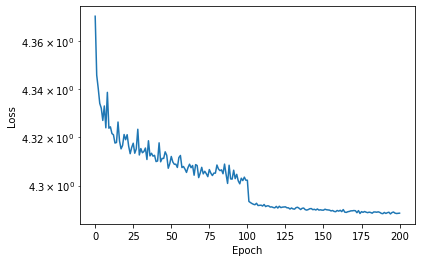

In [8]:
plt.plot(losses[1:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")

In [9]:
flow.save("saved-flows/conditional-flow.pzflow.pkl")

In [3]:
flow = Flow(file="saved-flows/conditional-flow.pzflow.pkl")

In [4]:
samples = flow.sample(1, conditions=data[:10_000], seed=0)
samples = samples[list(flow.conditional_columns) + list(flow.data_columns)]

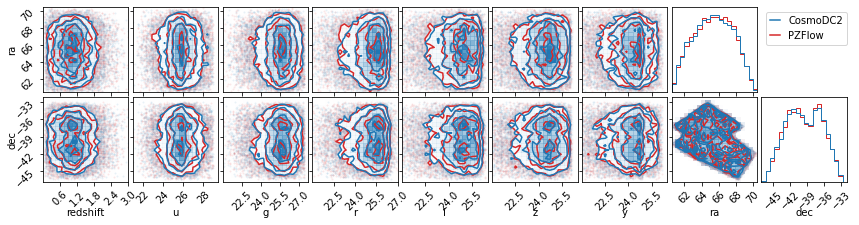

In [7]:
fig = plt.figure(figsize=(12,12))

# global settings for the plot
plot_settings = {
    "fig": fig,
    "range": [
        (0, 3),     # redshift
        (21, 29.5), # u
        (21, 27.7), # g
        (21, 27), # r
        (21, 26.5), # i
        (21, 26.5), # z
        (21, 26.5), # y
        (60.5, 70.5), # RA
        (-47, -32),   # Dec
    ],
    "bins": 20,
    "labels": samples.columns,
}

# plot the data
corner(samples, color="C3", **plot_settings)
corner(data[samples.columns][:samples.shape[0]], color="C0", **plot_settings)

# set the limits on the axes
axes = np.array(fig.axes).reshape(samples.shape[1], -1)
for i, R in enumerate(plot_settings["range"]):
    # set the x limits
    for ax in axes[:, i]:
        ax.set_xlim(R)
    # set the y limits
    if i > 0:
        for j, ax in enumerate(axes[i]):
            if j < i:
                ax.set_ylim(R)


# hide the unnecessary panels
for ax in axes[:-2].flatten():
    ax.set_visible(False)

# add the legend
axes[-2, -1].plot([], c="C0", label="CosmoDC2")
axes[-2, -1].plot([], c="C3", label="PZFlow")
axes[-2, -1].legend(loc=2, handlelength=1)

plt.show()